In [1]:
import numpy as np
from scipy.linalg import expm, kron
from itertools import combinations, product
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from QMultiAdapt.solver import solve_avq_vect
from QMultiAdapt.effh import VectorizedEffectiveHamiltonian
from QMultiAdapt.ansatzVect import Ansatz
import matplotlib.pyplot as plt

In [2]:
# Execution Code for Amplitude damping channel example
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2
Id = np.eye(2, dtype=np.complex128)

tf = 1000e-12
dt = 1000e-13
gamma = 1.52e9
H = np.eye(2, dtype=np.complex128)
lind = sp
H = VectorizedEffectiveHamiltonian(H, gamma, lind)
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128) #it should be normalized initial state with 2^n length

# u0 = np.array([0, 1], dtype=np.complex128)
ansatz = Ansatz(u0, relrcut=1e-6)
res = solve_avq_vect(H, ansatz, [0, tf], dt)


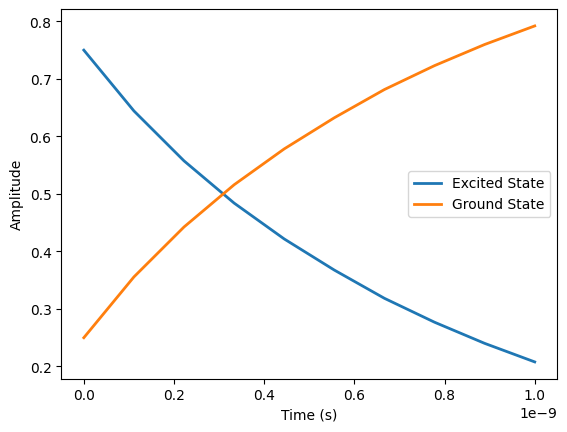

In [3]:

excited = [res.u[i][1, 1].real for i in range(10)]
ground = [res.u[i][0, 0].real for i in range(10)]
times = np.linspace(0, 1000e-12, 10)

plt.plot(times, excited, label="Excited State", linewidth=2)
plt.plot(times, ground, label="Ground State", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [4]:
from qutip import mesolve, Qobj
import numpy as np
import matplotlib.pyplot as plt
def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

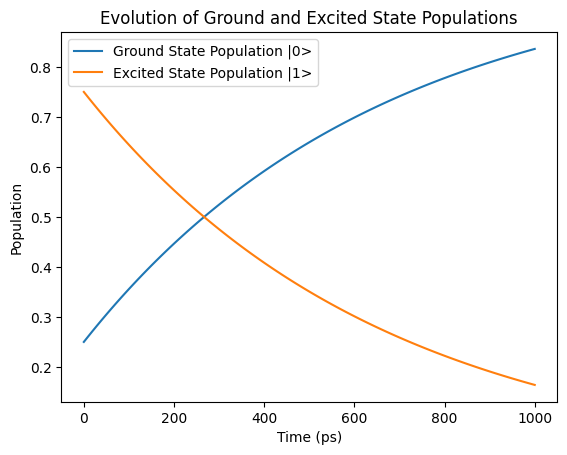

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Pauli matrices and lowering operator
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2
sm = Qobj(sp)  # collapse operator for amplitude damping

# Identity Hamiltonian (trivial in this case)
H = Qobj(np.eye(2, dtype=np.complex128))

# Time scale
tf = 1000e-12  # final time
dt = 1000e-14  # time step
times = np.arange(0, tf, dt)  # time array

# Amplitude damping rate
gamma = 1.52e9  # damping rate

# Initial state (normalize if necessary)
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128)
u0 = u0 / np.linalg.norm(u0)  # normalize the state
psi0 = Qobj(u0)  # initial state as Qobj
rho0 = psi0 * psi0.dag()  
# Collapse operators
c_ops = [np.sqrt(gamma) * sm]  # amplitude damping

# Define projectors for ground and excited states
proj_excited = basis(2, 1) * basis(2, 1).dag()  # |1><1|
proj_ground = basis(2, 0) * basis(2, 0).dag()   # |0><0|

# Solve the master equation using mesolve
result = qutip_prop(H, rho0, times, c_ops, [proj_ground, proj_excited])

# Extract ground and excited state populations
ground_population = result[0]  # <0|rho|0> (ground state population)
excited_population = result[1]  # <1|rho|1> (excited state population)

# Plotting results
plt.plot(times * 1e12, ground_population, label="Ground State Population |0>")
plt.plot(times * 1e12, excited_population, label="Excited State Population |1>")
plt.xlabel('Time (ps)')
plt.ylabel('Population')
plt.legend()
plt.title('Evolution of Ground and Excited State Populations')
plt.show()


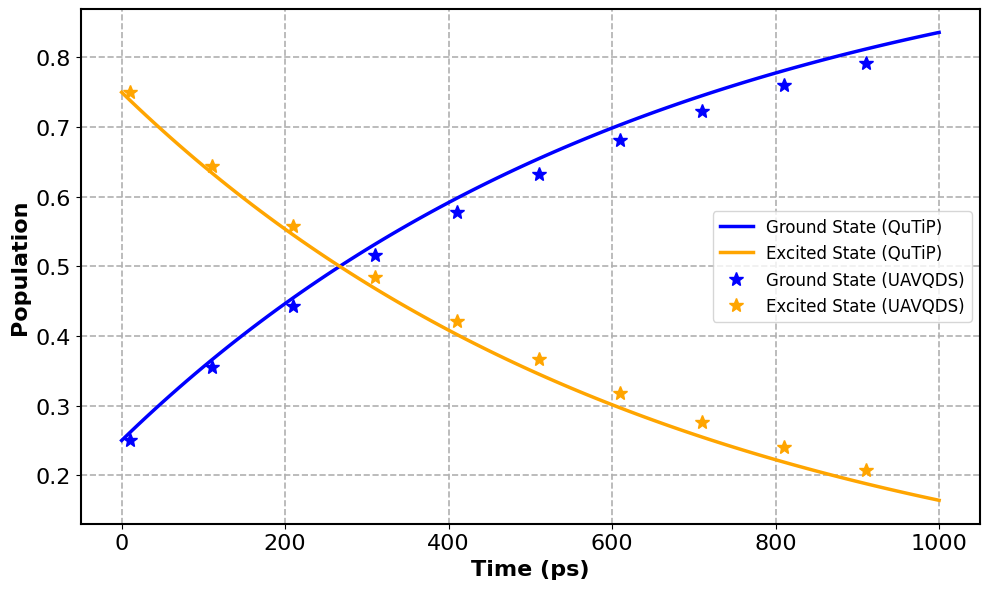

In [9]:
# Plotting results together
plt.figure(figsize=(10, 6))

# Line width and marker size
line_width = 2.5
marker_size = 10

# Define consistent colors for ground and excited states
ground_color = 'blue'
excited_color = 'orange'
uavqds_ground_color = 'blue'  # Same as QuTiP ground state
uavqds_excited_color = 'orange'  # Same as QuTiP excited state

# Plot QuTiP results
plt.plot(times * 1e12, ground_population, 
         label="Ground State (QuTiP)", 
         color=ground_color, linewidth=line_width)

plt.plot(times * 1e12, excited_population, 
         label="Excited State (QuTiP)", 
         color=excited_color, linewidth=line_width)

# Plot UAVQDS results with markers
plt.plot(times[1::10] * 1e12, ground, 
         '*', label="Ground State (UAVQDS)", 
         color=uavqds_ground_color, markersize=marker_size)

plt.plot(times[1::10] * 1e12, excited, 
         '*', label="Excited State (UAVQDS)", 
         color=uavqds_excited_color, markersize=marker_size)

# Customize plot appearance
plt.xlabel('Time (ps)', fontsize=16, fontweight='bold')
plt.ylabel('Population', fontsize=16, fontweight='bold')
# plt.title('Comparison of Ground and Excited State Populations', fontsize=16, fontweight='bold')

# Increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
# plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks, if any


# Increase font size of the legend and set it outside the plot
plt.legend(fontsize=12, loc='best')

# Make gridlines bolder
plt.grid(True, which='both', linestyle='--', linewidth=1.2)

# Increase the thickness of the plot borders
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("population_comparison.png", dpi=300)  # Save with high DPI for publication quality
plt.show()
